In [1]:
from astropy.io import fits
import pandas as pd
from astropy.table import Table
from astropy.table import vstack
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
Ncm.cfg_init()

0.3089-0.0486

0.26030000000000003

In [2]:

hdul = fits.open("halos.fits")

table = hdul[1].data

logMmin = 13.0
logMmax = 15.0
zmin    = 0.0
zmax    = 0.6646281966028926

halo_table = table[ (table['upid'] == -1) & (table['Mvir'] >= 10**logMmin) & (table['Mvir'] <= 10**logMmax) & (table['redshift_R'] >= zmin)]
#0.45
#15

halo_table['Mvir'] = halo_table['Mvir']/0.6774



print(halo_table.size)


print(np.log10(halo_table['Mvir'].min()))
print(np.log10(halo_table['Mvir'].max()))




print(halo_table['redshift_R'].min())
print(halo_table['redshift_R'].max())

print(halo_table['RA'].min())
print(halo_table['RA'].max())


689973
13.169588889509313
15.165841554539153
0.00388302828285513
0.6646281966028926
110.00007629394531
229.99951171875


In [3]:
area = 4109.3
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegac",0.3089 - 0.0486) #0.2603
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0) #-1.0


prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA",3.0116707481421923)
prim.param_set_by_name("n_SA", 0.9667)


reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)


dist = Nc.Distance.new(2.0)

tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
print("sigma8 = " + str(cosmo.sigma8(psf)))


A_s = np.exp(prim.param_get_by_name("ln10e10ASA")) * 1.0e-10
fact = (0.8159 / psml.sigma_tophat_R(cosmo, 1.0e-7, 0.0, 8.0 / 0.6774)) ** 2
prim.param_set_by_name("ln10e10ASA", np.log(1.0e10 * A_s * fact))
print(prim.param_get_by_name("ln10e10ASA"))

print("sigma8 = " + str(cosmo.sigma8(psf)))
print(prim.param_get_by_name("ln10e10ASA"))

mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)

mfunc_Omegam = Ncm.MSetFuncList.new("NcHICosmo:Omega_m0", None)
mfunc_oa.add(mfunc_Omegam)


mulf = Nc.MultiplicityFuncDespali.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)
hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area(area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)
hbias = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias)
cad.set_area(area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)

#σ_8 = 0.8159

#mass proxy
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * (logMmin - np.log10(0.6774)), lnM_max=np.log(10.0) * (logMmax - np.log10(0.6774)))

#photo-z
cluster_z = Nc.ClusterRedshiftNodist (z_min = zmin, z_max = zmax)

sigma8 = 0.8158999996211254
3.0116707481421923
sigma8 = 0.8158999996211254
3.0116707481421923


775722.0246816137
[13.16958889 13.18975306 13.20991723 13.23008139 13.25024556 13.27040973
 13.2905739  13.31073807 13.33090224 13.3510664  13.37123057 13.39139474
 13.41155891 13.43172308 13.45188725 13.47205141 13.49221558 13.51237975
 13.53254392 13.55270809 13.57287226 13.59303642 13.61320059 13.63336476
 13.65352893 13.6736931  13.69385727 13.71402143 13.7341856  13.75434977
 13.77451394 13.79467811 13.81484228 13.83500644 13.85517061 13.87533478
 13.89549895 13.91566312 13.93582729 13.95599145 13.97615562 13.99631979
 14.01648396 14.03664813 14.0568123  14.07697646 14.09714063 14.1173048
 14.13746897 14.15763314 14.17779731 14.19796147 14.21812564 14.23828981
 14.25845398 14.27861815 14.29878232 14.31894648 14.33911065 14.35927482
 14.37943899 14.39960316 14.41976733 14.43993149 14.46009566 14.48025983
 14.500424   14.52058817 14.54075234 14.5609165  14.58108067 14.60124484
 14.62140901 14.64157318 14.66173735 14.68190151 14.70206568 14.72222985
 14.74239402 14.76255819 14.782722

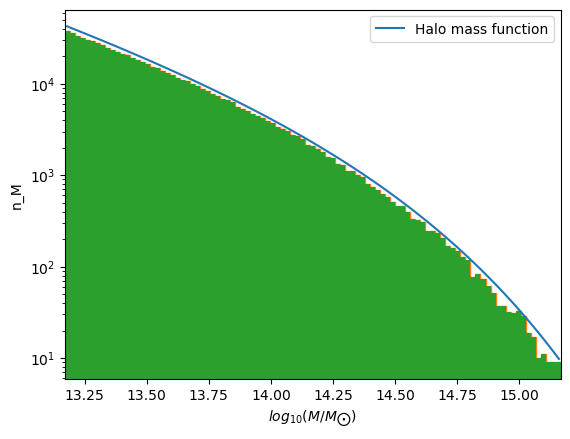

[37528 35473 33310 31981 30444 28988 27609 26501 24490 23576 22442 21149
 20520 19233 18281 17283 16248 15142 14765 13791 13097 12479 11661 11043
 10611  9914  9486  8868  8312  7786  7335  6834  6629  6267  5635  5336
  5089  4658  4482  4232  3868  3701  3395  3205  3016  2765  2667  2468
  2150  2106  1921  1771  1601  1523  1329  1277  1124  1105  1005   953
   797   748   684   622   578   511   464   465   400   335   323   306
   248   244   234   204   169   161   149   127   117    77    83    73
    61    52    37    37    32    31    33    29    19    17    10    11
     9     9     9]


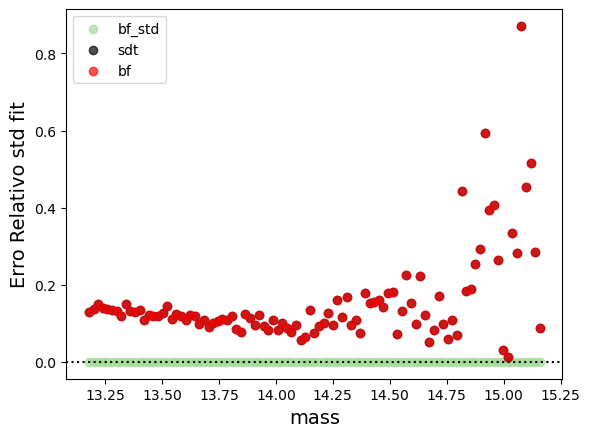

In [14]:
legend = ["standard" , "best_fit"]
params = [[0.3089-0.0486,-1.0,3.0116707481421923] , [0.25427954165518, -1.0, 2.99806019495157] ]

n_std = []
for param in range(len(params)):

    cosmo.param_set_by_name("Omegac",params[param][0]) 
    cosmo.param_set_by_name("w", params[param][1]) 
    prim.param_set_by_name("ln10e10ASA", params[param][2])
    
    mass = np.linspace(np.log(10) * (logMmin - np.log10(0.6774)), np.log(10.0) * (logMmax - np.log10(0.6774)), 100)
    mass10 = np.linspace(logMmin - np.log10(0.6774), logMmax - np.log10(0.6774), 100)
    mass_plot = []
    n_bin = []
    
    mulf = Nc.MultiplicityFuncDespali.new()
    mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)
    mulf.set_cmf(False)
    
    #mulf = Nc.MultiplicityFuncTinker.new()
    #mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
        
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.set_area(area * (np.pi / 180) ** 2)
    
    hmf.prepare(cosmo)
    cad = Nc.ClusterAbundance.new(hmf, hbias)
    hmf.prepare(cosmo)
    cad.prepare(cosmo , cluster_z , cluster_m)
    cad.set_area(area * (np.pi / 180) ** 2)
    print(cad.n(cosmo , cluster_z , cluster_m))
    for i in range(len(mass)-1):
        n_bin.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m , [mass[i]] ,[mass[i+1]],None ,[zmin] , [zmax] , None))
        if param ==0:
            n_std.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m , [mass[i]] ,[mass[i+1]],None ,[zmin] , [zmax] , None))
        mass_plot.append((mass10[i] + mass10[i+1])/2)
    
    
    
    
    
    plt.plot(mass_plot , n_bin , label = "%s" %(legend[param]))
    
plt.xlim(np.log10(halo_table['Mvir'].min()) , np.log10(halo_table['Mvir'].max()))
plt.legend()
plt.xlabel(r"$log_{10}(M/M_{\bigodot})$")
plt.ylabel(r"n_M")
plt.yscale("log")
counts, bins = np.histogram(np.log10(halo_table['Mvir']), bins=(len(mass10)-1))
plt.stairs(counts, bins)
print(bins)
plt.hist(np.log10(halo_table['Mvir']), bins=(len(mass10)-1))
plt.savefig("halo_mass_function_log10M.jpg")
plt.show()

diff = []
diff_std = []
diff_bin = []
for i in range(len(n_bin)):
    diff.append((n_std[i] - n_bin[i])/n_std[i])
    diff_std.append((n_std[i] - counts[i])/counts[i])
    diff_bin.append((n_bin[i] - counts[i])/counts[i])


plt.scatter(mass_plot, diff, c='#a0d995', alpha=0.6774 ,label = "bf_std")
plt.scatter(mass_plot, diff_std, c='black', alpha=0.6774 , label = "sdt")
plt.scatter(mass_plot, diff_bin, c='red', alpha=0.6774, label = "bf")
plt.legend()
plt.xlabel('mass', size=14)
plt.ylabel('Erro Relativo std fit', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted')
print(counts)

775722.0246816137


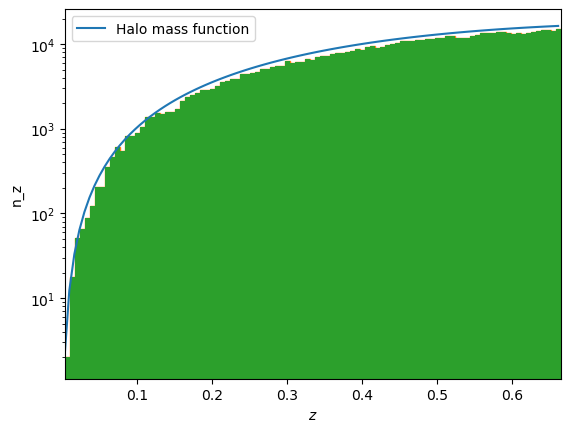

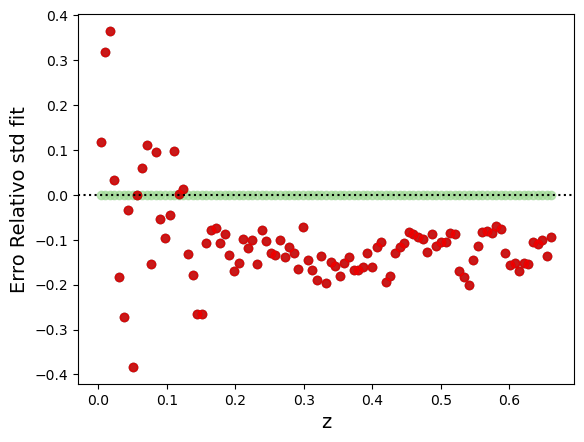

In [15]:
legend = ["standard" , "best_fit"]
params = [[0.3089-0.0486,-1.0,3.0116707481421923] ,  [0.25427954165518, -1.0, 2.99806019495157] ]

n_std = []

for param in range(len(params)):

    cosmo.param_set_by_name("Omegac",params[param][0]) 
    cosmo.param_set_by_name("w", params[param][1]) 
    prim.param_set_by_name("ln10e10ASA", params[param][2])
    
    z = np.linspace(zmin, zmax , 100)
    z_plot = []
    n_bin = []
    
    mulf = Nc.MultiplicityFuncDespali.new()
    mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)
    
    z = np.linspace(zmin, zmax , 100)
    z_plot = []
    n_bin = []
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.set_area(area * (np.pi / 180) ** 2)
    
    hmf.prepare(cosmo)
    cad = Nc.ClusterAbundance.new(hmf, None)
    hmf.prepare(cosmo)
    cad.prepare(cosmo , cluster_z , cluster_m)
    cad.set_area(area * (np.pi / 180) ** 2)
    print(cad.n(cosmo , cluster_z , cluster_m))
    for i in range(len(z)-1):
        n_bin.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m , [np.log(10)*(logMmin - np.log10(0.6774))] ,[np.log(10.0) * (logMmax - np.log10(0.6774))],None ,[z[i]] , [z[i+1]] , None))
        z_plot.append((z[i] + z[i+1])/2)
        if param ==0:
            n_std.append(cad.intp_bin_d2n(cosmo , cluster_z , cluster_m , [np.log(10)*(logMmin - np.log10(0.6774))] ,[np.log(10.0) * (logMmax - np.log10(0.6774))],None ,[z[i]] , [z[i+1]] , None))
            
    
    
    
    
    
    plt.plot(z_plot , n_bin , label = "%s" %(legend[param]))
    
plt.xlim(halo_table['redshift_R'].min() , halo_table['redshift_R'].max())
plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"n_z")
plt.yscale("log")
counts_z, bins = np.histogram(halo_table['redshift_R'], bins=(len(z)-1))
plt.stairs(counts_z, bins)
plt.hist(halo_table['redshift_R'], bins=(len(z)-1))
plt.savefig("halo_mass_function_z.jpg")
plt.show()

diff = []
diff_std = []
diff_bin = []
for i in range(len(n_bin)):
    diff.append((n_std[i] - n_bin[i])/n_std[i])
    diff_std.append((counts_z[i] - n_std[i])/counts_z[i])
    diff_bin.append((counts_z[i] - n_bin[i])/counts_z[i])
    

plt.scatter(z_plot, diff, c='#a0d995', alpha=0.6774)
plt.scatter(z_plot, diff_std, c='black', alpha=0.6774)
plt.scatter(z_plot, diff_bin, c='red', alpha=0.6774)

plt.xlabel('z', size=14)
plt.ylabel('Erro Relativo std fit', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted')

In [6]:
#Unbinned test
cosmo.param_set_by_name("w",-1.0)
cosmo.param_set_by_name("Omegac",0.3089 - 0.0486)
prim.param_set_by_name("ln10e10ASA",3.0116707481421923)

cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", False)
prim.set_property("ln10e10ASA_fit", True)

mulf = Nc.MultiplicityFuncDespali.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)

#mulf = Nc.MultiplicityFuncTinker.new()
#mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)    
hmf.prepare(cosmo)
hmf.set_area(area * (np.pi / 180) ** 2)

cad = Nc.ClusterAbundance.new(hmf, None)
cad.prepare(cosmo , cluster_z , cluster_m)

mset = Ncm.MSet.new_array([cosmo, cluster_m, cluster_z])
ncdata = Nc.DataClusterNCount.new(cad, "NcClusterRedshiftNodist", "NcClusterMassNodist")
ncdata.set_init(True)

lnM = np.array(np.log(halo_table['Mvir']))
redshift = np.array(halo_table['redshift_R'])

ncdata.set_lnM_obs(Ncm.Matrix.new_array(lnM, 1))
ncdata.set_z_obs(Ncm.Matrix.new_array(redshift, 1))
ncdata.set_lnM_true(Ncm.Vector.new_array(lnM))
ncdata.set_z_true(Ncm.Vector.new_array(redshift))
               
dset = Ncm.Dataset.new_array([ncdata])
likelihood = Ncm.Likelihood.new(dset)

experiment = Ncm.ObjDictStr()
experiment.set("likelihood", likelihood)
experiment.set("model-set", mset)
ser = Ncm.Serialize.new(Ncm.SerializeOpt.CLEAN_DUP)
ser.dict_str_to_yaml_file(experiment, "unbinned_halos_jpas.yaml")
ser.array_to_yaml_file(mfunc_oa, "unbinned_halos_jpas.functions.yaml")

In [7]:
def create_zbins_kernels(
    z_min: float = 0.1,
    z_max: float = 0.8,
    nknots: int = 8,
    kernel_nknots: int = 400,
    kernel_zmax: float = 1.9,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Create the redshift bins and kernels for the J-Pas 2024 forecast."""

    # Redshift bins and kernels

    z_bins_len = nknots - 1
    z_bins_knots = np.linspace(z_min, z_max, num=nknots)

    kernel_z = np.linspace(0.2, kernel_zmax, num=kernel_nknots + 1)[1:]

    kernels_T = np.zeros((z_bins_len, kernel_nknots))

    for i, (zminbin, zmaxbin) in enumerate(zip(z_bins_knots[:-1], z_bins_knots[1:])):
        Dz = zmaxbin - zminbin

        kernel = np.zeros_like(kernel_z)
        kernel[(kernel_z >= zminbin) & (kernel_z <= zmaxbin)] = 1.0
        kernels_T[i] = kernel / Dz

    return kernel_z, kernels_T, z_bins_knots

def create_covariance_S_fullsky(
    kernel_z: np.ndarray, kernels_T: np.ndarray, cosmo: Nc.HICosmo
) -> Ncm.Matrix:
    """Create the base covariance matrix S_ij for the J-Pas 2024 forecast
    based on the full sky."""

    S_fullsky_array = PySSC.Sij(kernel_z, kernels_T, cosmo)

    S_fullsky = Ncm.Matrix.new_array(
        S_fullsky_array.flatten(), S_fullsky_array.shape[1]
    )

    return S_fullsky

kernel_z, kernels_T, z_bins_knots = create_zbins_kernels(z_min = zmin, z_max = zmax , nknots = 2)
S = create_covariance_S_fullsky(kernel_z,kernels_T,cosmo)


In [8]:
rng = Ncm.RNG.seeded_new(None, 1234)

In [9]:
#Binned test
counts, bins = np.histogram(np.log10(halo_table['Mvir']), bins=(9))

#mulf = Nc.MultiplicityFuncDespali.new()
#mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)

mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)


hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias = Nc.HaloBiasTinker.new(hmf)
hmf.prepare(cosmo)
hmf.set_area(area * (np.pi / 180) ** 2)

cad = Nc.ClusterAbundance.new(hmf, hbias)
cad.prepare(cosmo , cluster_z , cluster_m)

mset = Ncm.MSet.new_array([cosmo, cluster_m, cluster_z])

mass = np.linspace(np.log(10) * (logMmin- np.log10(0.6774)), np.log(10.0) * (logMmax- np.log10(0.6774)), 10)
z = np.linspace(zmin, zmax , 2)

z_bins_vec = Ncm.Vector.new_array(z)
lnM_bins_vec = Ncm.Vector.new_array(mass)

ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_bins_vec.len() - 1) * (lnM_bins_vec.len() - 1))
ncounts_gauss.set_init(True)

ncounts_gauss.use_norma(True)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.set_s_matrix(S)
ncounts_gauss.set_z_obs(z_bins_vec)
ncounts_gauss.set_lnM_obs(lnM_bins_vec)

ncounts_gauss.resample(mset,rng)
for i in range(len(counts)): 
    ncounts_gauss.peek_mean().set(i,counts[i]) 


dset = Ncm.Dataset.new_array([ncounts_gauss])
likelihood = Ncm.Likelihood.new(dset)

experiment = Ncm.ObjDictStr()
experiment.set("likelihood", likelihood)
experiment.set("model-set", mset)
ser = Ncm.Serialize.new(Ncm.SerializeOpt.CLEAN_DUP)
ser.dict_str_to_yaml_file(experiment, "binned_halos_jpas.yaml")
ser.array_to_yaml_file(mfunc_oa, "binned_halos_jpas.functions.yaml")